In [11]:
# Base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [12]:
# Cargar datasets
orders = pd.read_csv('../data/raw/olist_orders_dataset.csv',
                     parse_dates=['order_purchase_timestamp',
                                  'order_delivered_carrier_date',
                                  'order_delivered_customer_date',
                                  'order_estimated_delivery_date'])

items = pd.read_csv('../data/raw/olist_order_items_dataset.csv')
products = pd.read_csv('../data/raw/olist_products_dataset.csv')
reviews = pd.read_csv('../data/raw/olist_order_reviews_dataset.csv')
payments = pd.read_csv('../data/raw/olist_order_payments_dataset.csv')


print("Shapes de los datasets:")
print(f"Orders: {orders.shape}")
print(f"Items: {items.shape}")
print(f"Products: {products.shape}")
print(f"Reviews: {reviews.shape}")
print(f"Payments: {payments.shape}\n")


Shapes de los datasets:
Orders: (99441, 8)
Items: (112650, 7)
Products: (32951, 9)
Reviews: (99224, 7)
Payments: (103886, 5)



In [13]:
####  UNIÓN DE DATASETS
# Unir todas las tablas
df = orders.merge(items, on='order_id', how='left')
df = df.merge(products, on='product_id', how='left')
df = df.merge(reviews, on='order_id', how='left')
df = df.merge(payments, on='order_id', how='left')

print(f"Shape después del merge: {df.shape}")
print(f"Columnas disponibles: {df.columns.tolist()}\n")

Shape después del merge: (119143, 32)
Columnas disponibles: ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'review_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']



In [14]:
####  CONSTRUCCIÓN DE LA VARIABLE TARGET 

# 1. Filtrar solo órdenes entregadas
df_delivered = df[df['order_status'] == 'delivered'].copy()
print(f"Órdenes totales: {len(df)}")
print(f"Órdenes entregadas: {len(df_delivered)}")

# 2. Crear variable de mes-año para agrupación
df_delivered['purchase_year_month'] = df_delivered['order_purchase_timestamp'].dt.to_period('M')
print(f"Rango temporal: {df_delivered['purchase_year_month'].min()} a {df_delivered['purchase_year_month'].max()}")

# 3. Calcular demanda mensual por categoría (unidades vendidas)
monthly_demand = df_delivered.groupby(['purchase_year_month', 'product_category_name']).agg({
    'product_id': 'count',  # Contar unidades vendidas
    'price': 'sum',         # Ventas totales en valor
    'freight_value': 'sum', # Valor total del flete
    'order_id': 'nunique'   # Número de órdenes únicas
}).reset_index()

monthly_demand.rename(columns={
    'product_id': 'monthly_demand_units',
    'price': 'monthly_demand_value',
    'freight_value': 'monthly_freight_value',
    'order_id': 'monthly_orders_count'
}, inplace=True)

print(f"Registros de demanda mensual: {len(monthly_demand)}")

# 4. Crear la variable target: demanda del siguiente mes
monthly_demand = monthly_demand.sort_values(['product_category_name', 'purchase_year_month'])
monthly_demand['demand_next_month'] = monthly_demand.groupby('product_category_name')['monthly_demand_units'].shift(-1)

print("\n=== EJEMPLO DE LA VARIABLE TARGET ===")
# Mostrar ejemplo para una categoría específica
example_category = monthly_demand['product_category_name'].iloc[0]
example_data = monthly_demand[monthly_demand['product_category_name'] == example_category].head(5)
print(example_data[['purchase_year_month', 'product_category_name', 'monthly_demand_units', 'demand_next_month']])


Órdenes totales: 119143
Órdenes entregadas: 115723
Rango temporal: 2016-09 a 2018-08
Registros de demanda mensual: 1252

=== EJEMPLO DE LA VARIABLE TARGET ===
    purchase_year_month      product_category_name  monthly_demand_units  \
31              2017-01  agro_industria_e_comercio                     3   
73              2017-02  agro_industria_e_comercio                     9   
123             2017-03  agro_industria_e_comercio                     2   
232             2017-05  agro_industria_e_comercio                     4   
291             2017-06  agro_industria_e_comercio                     1   

     demand_next_month  
31                 9.0  
73                 2.0  
123                4.0  
232                1.0  
291                1.0  


In [15]:
#### ANÁLISIS DE COMPLETITUD DE LA TARGET 
print(f"Registros totales: {len(monthly_demand)}")
print(f"Registros con target disponible: {monthly_demand['demand_next_month'].notna().sum()}")
print(f"Porcentaje de completitud: {monthly_demand['demand_next_month'].notna().mean()*100:.1f}%")

# Filtrar solo registros con target disponible
monthly_demand_clean = monthly_demand[monthly_demand['demand_next_month'].notna()].copy()

Registros totales: 1252
Registros con target disponible: 1179
Porcentaje de completitud: 94.2%


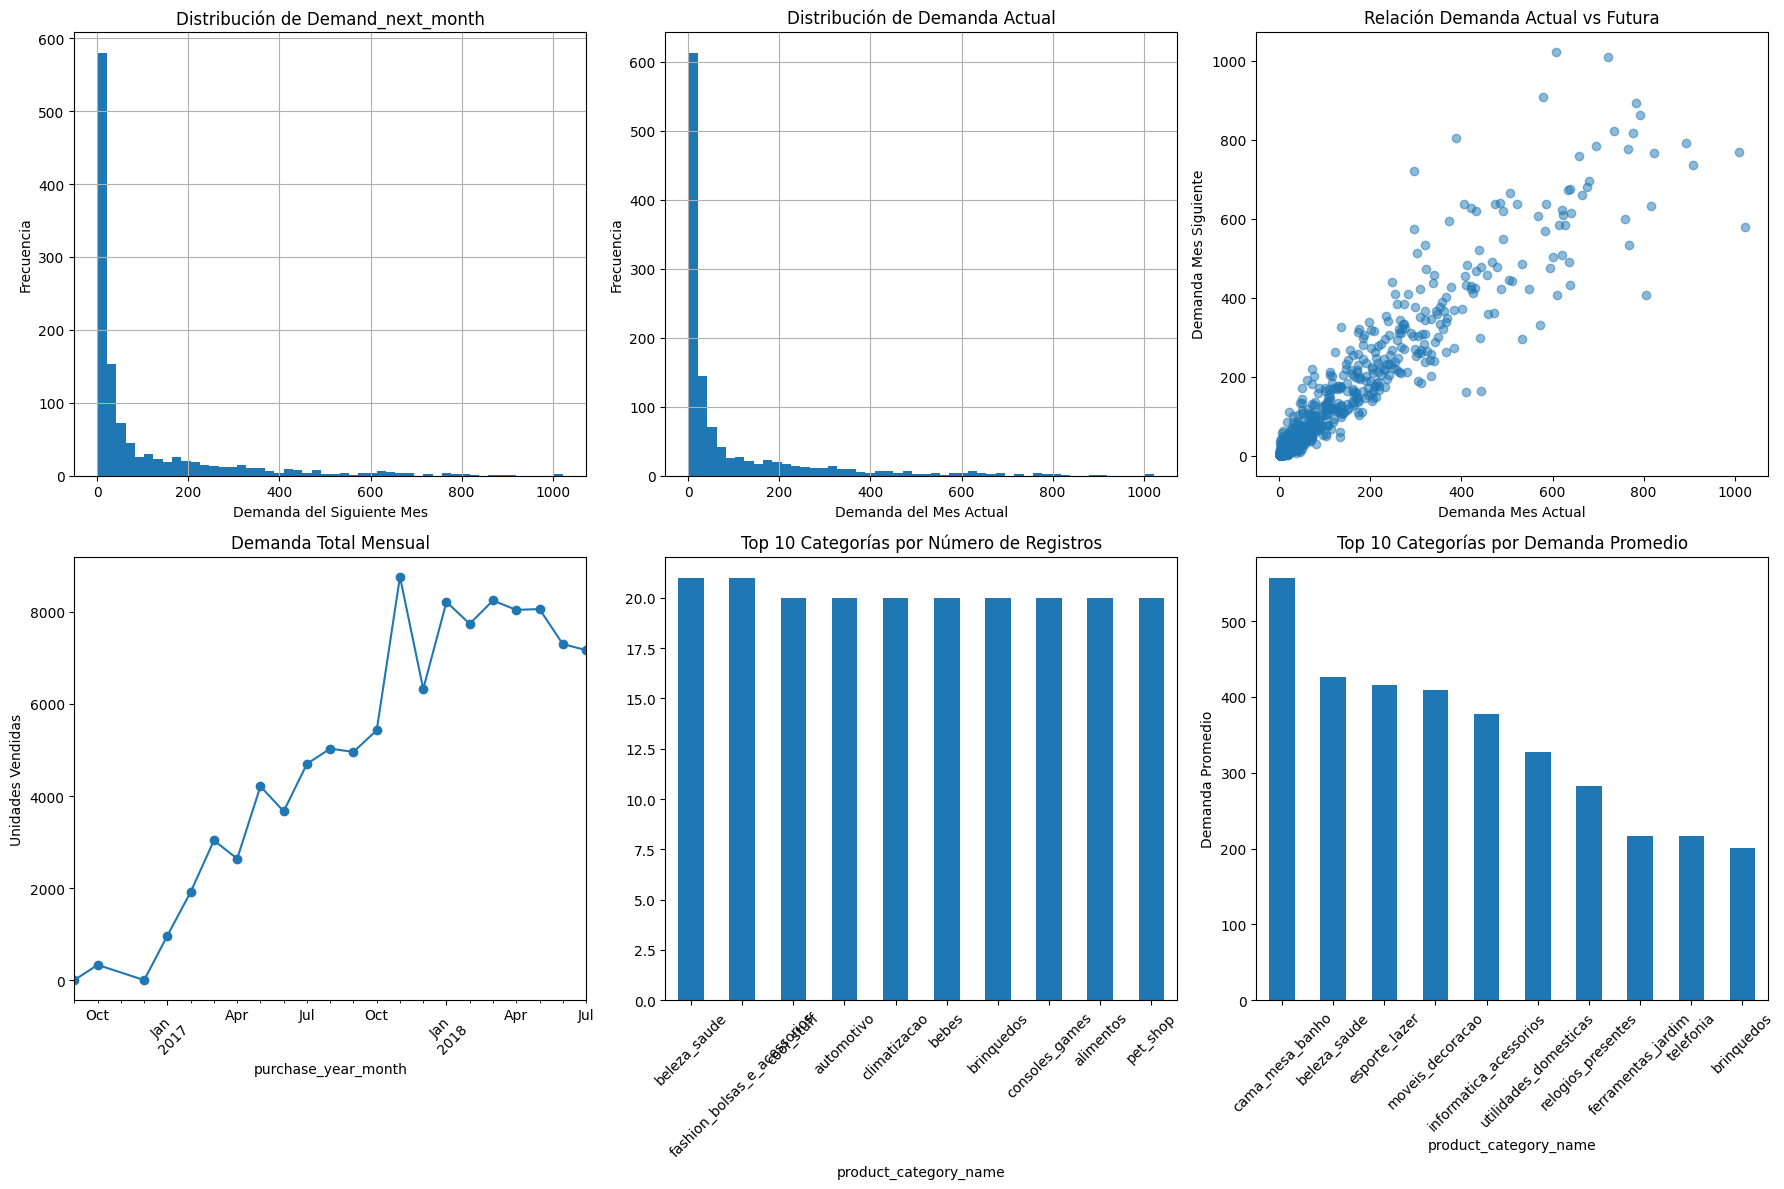

In [16]:
#### VISUALIZACIONES

# 1. Distribuciones
plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
monthly_demand_clean['demand_next_month'].hist(bins=50)
plt.title('Distribución de Demand_next_month')
plt.xlabel('Demanda del Siguiente Mes')
plt.ylabel('Frecuencia')

plt.subplot(2, 3, 2)
monthly_demand_clean['monthly_demand_units'].hist(bins=50)
plt.title('Distribución de Demanda Actual')
plt.xlabel('Demanda del Mes Actual')
plt.ylabel('Frecuencia')

plt.subplot(2, 3, 3)
# Relación entre demanda actual y futura
plt.scatter(monthly_demand_clean['monthly_demand_units'], 
           monthly_demand_clean['demand_next_month'], alpha=0.5)
plt.xlabel('Demanda Mes Actual')
plt.ylabel('Demanda Mes Siguiente')
plt.title('Relación Demanda Actual vs Futura')

# 2. Análisis temporal
plt.subplot(2, 3, 4)
demand_by_month = monthly_demand_clean.groupby('purchase_year_month')['monthly_demand_units'].sum()
demand_by_month.plot(kind='line', marker='o')
plt.title('Demanda Total Mensual')
plt.xticks(rotation=45)
plt.ylabel('Unidades Vendidas')

plt.subplot(2, 3, 5)
top_categories_count = monthly_demand_clean['product_category_name'].value_counts().head(10)
top_categories_count.plot(kind='bar')
plt.title('Top 10 Categorías por Número de Registros')
plt.xticks(rotation=45)

plt.subplot(2, 3, 6)
avg_demand_by_category = monthly_demand_clean.groupby('product_category_name')['monthly_demand_units'].mean().sort_values(ascending=False).head(10)
avg_demand_by_category.plot(kind='bar')
plt.title('Top 10 Categorías por Demanda Promedio')
plt.xticks(rotation=45)
plt.ylabel('Demanda Promedio')

plt.tight_layout()
plt.show()

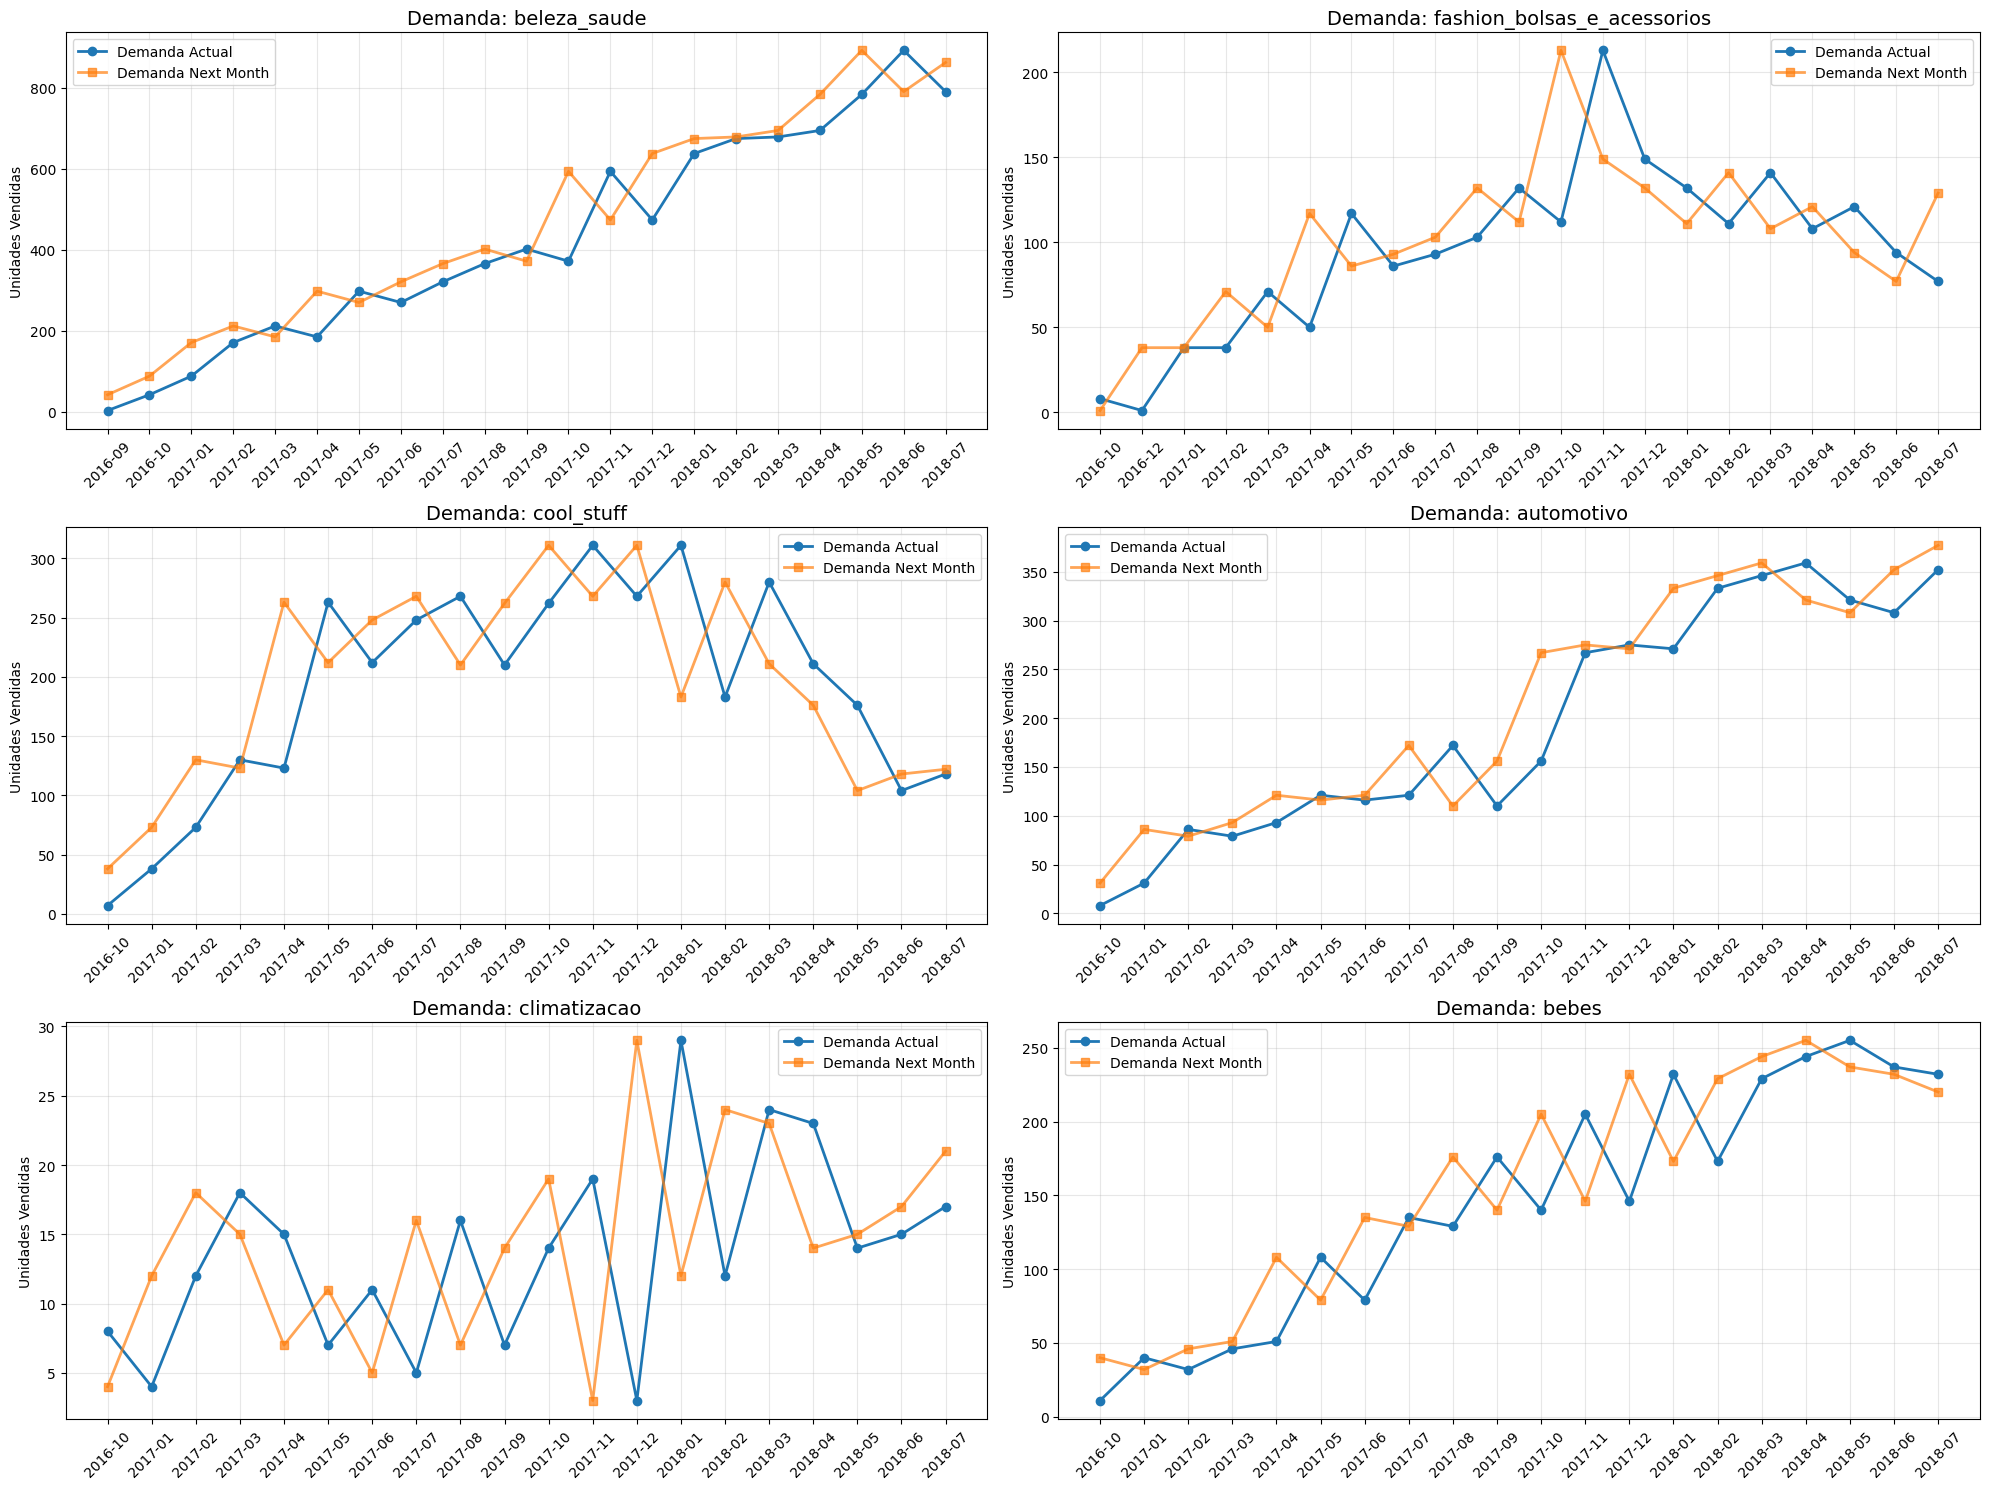

In [17]:
#### ANÁLISIS POR CATEGORÍA

# Identificar las categorías con más datos
top_categories = monthly_demand_clean['product_category_name'].value_counts().head(6).index

plt.figure(figsize=(20, 15))

for i, category in enumerate(top_categories):
    plt.subplot(3, 2, i+1)
    category_data = monthly_demand_clean[monthly_demand_clean['product_category_name'] == category]
    
    plt.plot(category_data['purchase_year_month'].astype(str), 
             category_data['monthly_demand_units'], 
             marker='o', linewidth=2, label='Demanda Actual')
    plt.plot(category_data['purchase_year_month'].astype(str), 
             category_data['demand_next_month'], 
             marker='s', linewidth=2, label='Demanda Next Month', alpha=0.7)
    
    plt.title(f'Demanda: {category}', fontsize=14)
    plt.xticks(rotation=45)
    plt.legend()
    plt.ylabel('Unidades Vendidas')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [18]:
######## LIMPIEZA DE DATOS 



class DataLoader:
    """Clase para carga y limpieza avanzada de datos"""
    
    def __init__(self):
        self.data = {}
        
    def clean_orders(self, orders):
        """Limpieza específica de orders"""
        print("🧹 Limpiando orders...")
        
        # Seleccionar columnas relevantes
        orders_columns = [
            'order_id', 'customer_id', 'order_purchase_timestamp',
            'order_delivered_carrier_date', 'order_delivered_customer_date',
            'order_estimated_delivery_date', 'order_status'
        ]
        
        available_cols = [col for col in orders_columns if col in orders.columns]
        orders_clean = orders[available_cols].copy()
        
        # Filtrar solo pedidos entregados
        orders_clean = orders_clean[orders_clean['order_status'] == 'delivered'].copy()
        
        # Eliminar duplicados
        orders_clean = orders_clean.drop_duplicates(subset=['order_id'])
        
        # Eliminar nulos en fecha de compra
        orders_clean = orders_clean.dropna(subset=['order_purchase_timestamp'])
        
        print(f"   ✅ Orders limpias: {orders_clean.shape}")
        return orders_clean
    
    def clean_items(self, items):
        """Limpieza específica de items"""
        print("🧹 Limpiando items...")
        items_clean = items.copy()
        
        items_clean = items_clean.drop_duplicates()
        items_clean = items_clean[items_clean['price'] > 0]
        items_clean = items_clean[items_clean['freight_value'] >= 0]
        
        print(f"   ✅ Items limpios: {items_clean.shape}")
        return items_clean
    
    def clean_products(self, products):
        """Limpieza específica de products"""
        print("🧹 Limpiando products...")
        products_clean = products.copy()
        
        # Normalizar categorías
        products_clean['product_category_name'] = (
            products_clean['product_category_name']
            .astype(str)
            .str.lower()
            .str.replace(" ", "_")
            .str.replace("-", "_")
        )
        
        # Convertir dimensiones a numéricas
        numeric_cols = ['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']
        for col in numeric_cols:
            if col in products_clean.columns:
                products_clean[col] = pd.to_numeric(products_clean[col], errors='coerce')
        
        products_clean = products_clean.drop_duplicates(subset=['product_id'])
        
        print(f"   ✅ Products limpios: {products_clean.shape}")
        return products_clean
    
    def clean_payments(self, payments):
        """Limpieza específica de payments"""
        print("🧹 Limpiando payments...")
        payments_clean = payments.copy()
        
        payments_clean = payments_clean.drop_duplicates()
        payments_clean['payment_value'] = pd.to_numeric(payments_clean['payment_value'], errors='coerce')
        payments_clean = payments_clean[payments_clean['payment_value'] >= 0]
        
        print(f"   ✅ Payments limpios: {payments_clean.shape}")
        return payments_clean
    
    def clean_reviews(self, reviews):
        """Limpieza específica de reviews"""
        print("🧹 Limpiando reviews...")
        reviews_clean = reviews.copy()
        
        reviews_clean = reviews_clean.drop_duplicates(subset=['order_id'])
        reviews_clean['review_score'] = pd.to_numeric(reviews_clean['review_score'], errors='coerce')
        
        # Limpiar fechas
        date_cols = ['review_creation_date', 'review_answer_timestamp']
        for col in date_cols:
            if col in reviews_clean.columns:
                reviews_clean[col] = pd.to_datetime(reviews_clean[col], errors='coerce')
        
        print(f"   ✅ Reviews limpias: {reviews_clean.shape}")
        return reviews_clean
    
    def clean_all_data(self, df_dict):
        """Ejecuta toda la limpieza en el dataset combinado"""
        print("\n" + "="*50)
        print("INICIANDO LIMPIEZA AVANZADA DE DATOS")
        print("="*50)
        
        # Extraer datos individuales del dataset combinado
        cleaned_data = {}
        
        # Orders: extraer y limpiar
        if 'order_id' in df_dict.columns:
            orders_cols = ['order_id', 'customer_id', 'order_purchase_timestamp', 
                          'order_delivered_carrier_date', 'order_delivered_customer_date',
                          'order_estimated_delivery_date', 'order_status']
            available_orders_cols = [col for col in orders_cols if col in df_dict.columns]
            orders_subset = df_dict[available_orders_cols].drop_duplicates()
            cleaned_data['orders_clean'] = self.clean_orders(orders_subset)
        
        # Items: extraer y limpiar
        if 'order_id' in df_dict.columns and 'product_id' in df_dict.columns:
            items_cols = ['order_id', 'product_id', 'price', 'freight_value']
            available_items_cols = [col for col in items_cols if col in df_dict.columns]
            items_subset = df_dict[available_items_cols].drop_duplicates()
            cleaned_data['items_clean'] = self.clean_items(items_subset)
        
        # Products: extraer y limpiar
        if 'product_id' in df_dict.columns:
            products_cols = ['product_id', 'product_category_name', 'product_weight_g', 
                           'product_length_cm', 'product_height_cm', 'product_width_cm']
            available_products_cols = [col for col in products_cols if col in df_dict.columns]
            products_subset = df_dict[available_products_cols].drop_duplicates(subset=['product_id'])
            cleaned_data['products_clean'] = self.clean_products(products_subset)
        
        # Payments: extraer y limpiar
        if 'order_id' in df_dict.columns:
            payments_cols = ['order_id', 'payment_value', 'payment_installments', 'payment_type']
            available_payments_cols = [col for col in payments_cols if col in df_dict.columns]
            payments_subset = df_dict[available_payments_cols].drop_duplicates()
            cleaned_data['payments_clean'] = self.clean_payments(payments_subset)
        
        # Reviews: extraer y limpiar
        if 'order_id' in df_dict.columns:
            reviews_cols = ['order_id', 'review_score', 'review_creation_date', 'review_answer_timestamp']
            available_reviews_cols = [col for col in reviews_cols if col in df_dict.columns]
            reviews_subset = df_dict[available_reviews_cols].drop_duplicates(subset=['order_id'])
            cleaned_data['reviews_clean'] = self.clean_reviews(reviews_subset)
        
        print("✅ Limpieza avanzada completada!")
        return cleaned_data

# Aplicar limpieza avanzada
print("🔧 Aplicando limpieza avanzada al dataset...")
loader = DataLoader()
cleaned_datasets = loader.clean_all_data(df)

# Mostrar resultados de la limpieza
print("\n📊 RESUMEN DE LIMPIEZA:")
for dataset_name, dataset in cleaned_datasets.items():
    print(f"   • {dataset_name}: {dataset.shape}")

🔧 Aplicando limpieza avanzada al dataset...

INICIANDO LIMPIEZA AVANZADA DE DATOS
🧹 Limpiando orders...
   ✅ Orders limpias: (96478, 7)
🧹 Limpiando items...
   ✅ Items limpios: (102425, 4)
🧹 Limpiando products...
   ✅ Products limpios: (32952, 6)
🧹 Limpiando payments...
   ✅ Payments limpios: (103272, 4)
🧹 Limpiando reviews...
   ✅ Reviews limpias: (99441, 4)
✅ Limpieza avanzada completada!

📊 RESUMEN DE LIMPIEZA:
   • orders_clean: (96478, 7)
   • items_clean: (102425, 4)
   • products_clean: (32952, 6)
   • payments_clean: (103272, 4)
   • reviews_clean: (99441, 4)


In [30]:
##### VERIFICACIÓN DE CALIDAD POST-LIMPIEZA



# Verificar integridad de los datos limpios
if 'orders_clean' in cleaned_datasets:
    orders_clean = cleaned_datasets['orders_clean']
    print(f"📋 Orders limpias:")
    print(f"   • Entregadas: {len(orders_clean)} órdenes")
    print(f"   • Período: {orders_clean['order_purchase_timestamp'].min()} a {orders_clean['order_purchase_timestamp'].max()}")
    print(f"   • Sin duplicados: {orders_clean['order_id'].nunique() == len(orders_clean)}")

if 'items_clean' in cleaned_datasets:
    items_clean = cleaned_datasets['items_clean']
    print(f"📦 Items limpios:")
    print(f"   • Precios válidos: {(items_clean['price'] > 0).sum()}")
    print(f"   • Fletes no negativos: {(items_clean['freight_value'] >= 0).sum()}")

if 'products_clean' in cleaned_datasets:
    products_clean = cleaned_datasets['products_clean']
    print(f"🏷️ Products limpios:")
    print(f"   • Categorías únicas: {products_clean['product_category_name'].nunique()}")
    print(f"   • Sin duplicados: {products_clean['product_id'].nunique() == len(products_clean)}")

📋 Orders limpias:
   • Entregadas: 96478 órdenes
   • Período: 2016-09-15 12:16:38 a 2018-08-29 15:00:37
   • Sin duplicados: True
📦 Items limpios:
   • Precios válidos: 102425
   • Fletes no negativos: 102425
🏷️ Products limpios:
   • Categorías únicas: 74
   • Sin duplicados: False


In [31]:
##### CREAR DATASET LIMPIO COMBINADO

# Combinar datasets limpios
df_clean = df.copy()

# Aplicar filtros basados en la limpieza
if 'orders_clean' in cleaned_datasets:
    valid_order_ids = cleaned_datasets['orders_clean']['order_id']
    df_clean = df_clean[df_clean['order_id'].isin(valid_order_ids)]

if 'products_clean' in cleaned_datasets:
    valid_product_ids = cleaned_datasets['products_clean']['product_id']
    df_clean = df_clean[df_clean['product_id'].isin(valid_product_ids)]

# Aplicar otras reglas de limpieza
df_clean = df_clean[df_clean['price'] > 0]
df_clean = df_clean[df_clean['freight_value'] >= 0]

print(f"✅ Dataset limpio combinado: {df_clean.shape}")
print(f"   • Reducción: {len(df) - len(df_clean)} filas eliminadas")
print(f"   • Eficiencia: {(len(df_clean)/len(df))*100:.1f}% de datos conservados")

✅ Dataset limpio combinado: (115723, 32)
   • Reducción: 3420 filas eliminadas
   • Eficiencia: 97.1% de datos conservados


In [32]:
### COMPARATIVA ANTES/DESPUÉS DE LA LIMPIEZA



# Calcular métricas de calidad
def calculate_data_quality(df, name):
    """Calcula métricas de calidad de datos"""
    quality = {
        'dataset': name,
        'filas': len(df),
        'nulos_total': df.isnull().sum().sum(),
        'nulos_porcentaje': (df.isnull().sum().sum() / (len(df) * len(df.columns))) * 100,
        'duplicados': df.duplicated().sum(),
        'precios_invalidos': (df['price'] <= 0).sum() if 'price' in df.columns else 0,
        'fletes_negativos': (df['freight_value'] < 0).sum() if 'freight_value' in df.columns else 0
    }
    return quality

# Comparar calidad antes y después
quality_before = calculate_data_quality(df, "Original")
quality_after = calculate_data_quality(df_clean, "Limpio")

quality_df = pd.DataFrame([quality_before, quality_after])
print(quality_df.to_string(index=False))

 dataset  filas  nulos_total  nulos_porcentaje  duplicados  precios_invalidos  fletes_negativos
Original 119143       202314          5.306491           0                  0                 0
  Limpio 115723       179880          4.857505           0                  0                 0



CONTINUANDO CON DATOS LIMPIOS
📅 Creando columna purchase_year_month...
🔍 Verificando columnas disponibles...
Columnas en df_clean: ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'review_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value', 'purchase_year_month']
📊 Agregando datos por mes y categoría...
✅ Datos agregados: (1252, 4)
🎯 Recalculando variable target...
📊 Datos limpios para modelado: (1179, 5)
🎯 Target disponible: 1179

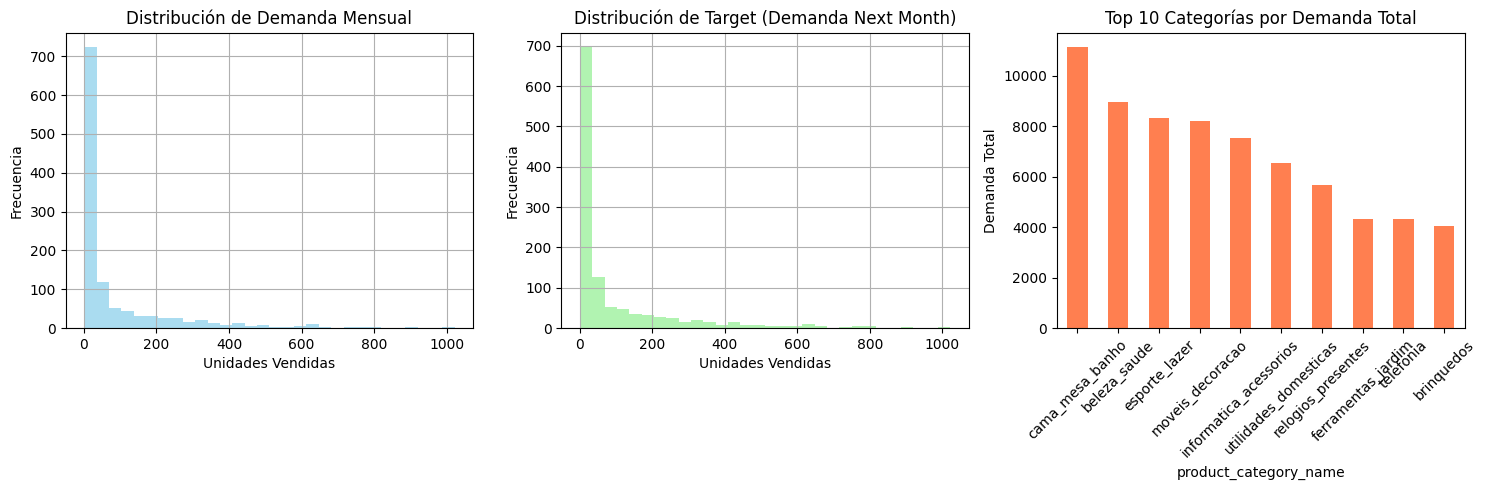


=== VERIFICACIÓN FINAL ===
🔍 Verificando valores nulos...
Valores nulos por columna:
   • purchase_year_month: 0 nulos
   • product_category_name: 0 nulos
   • monthly_demand_units: 0 nulos
   • monthly_demand_value: 0 nulos
   • demand_next_month: 0 nulos

📊 Estadísticas por categoría:
   • Total categorías: 73
   • Categorías con >12 meses: 60

🏆 Top 5 categorías por volumen:
   1. cama_mesa_banho: 11141 unidades
   2. beleza_saude: 8953 unidades
   3. esporte_lazer: 8314 unidades
   4. moveis_decoracao: 8185 unidades
   5. informatica_acessorios: 7539 unidades

PREPARADO PARA INGENIERÍA DE CARACTERÍSTICAS
✅ Dataset limpio listo para feature engineering:
   • Shape: (1179, 5)
   • Columnas: ['purchase_year_month', 'product_category_name', 'monthly_demand_units', 'monthly_demand_value', 'demand_next_month']
   • Rango temporal: 2016-09 a 2018-07
   • Categorías: 73


In [33]:
#### CONTINUAR CON EL PREPROCESAMIENTO (usando datos limpios)


print("\n" + "="*60)
print("CONTINUANDO CON DATOS LIMPIOS")
print("="*60)

# CREAR LA COLUMNA purchase_year_month QUE FALTA
print("📅 Creando columna purchase_year_month...")
df_clean['purchase_year_month'] = df_clean['order_purchase_timestamp'].dt.to_period('M').astype(str)

# Verificar que las columnas necesarias existen
print("🔍 Verificando columnas disponibles...")
print(f"Columnas en df_clean: {list(df_clean.columns)}")

# Verificar que tenemos las columnas necesarias
required_columns = ['purchase_year_month', 'product_category_name', 'product_id', 'price']
missing_columns = [col for col in required_columns if col not in df_clean.columns]

if missing_columns:
    print(f"❌ Columnas faltantes: {missing_columns}")
    print("💡 Creando columnas faltantes...")
    
    # Crear columnas faltantes si es necesario
    if 'product_category_name' not in df_clean.columns and 'products_clean' in cleaned_datasets:
        # Obtener categorías de products_clean
        category_mapping = cleaned_datasets['products_clean'][['product_id', 'product_category_name']].drop_duplicates()
        df_clean = df_clean.merge(category_mapping, on='product_id', how='left')
        print("✅ Columna product_category_name añadida desde products_clean")
    
    # Si aún falta product_category_name, crear una genérica
    if 'product_category_name' not in df_clean.columns:
        df_clean['product_category_name'] = 'unknown_category'
        print("✅ Columna product_category_name creada como 'unknown_category'")

# Actualizar monthly_demand_clean con datos limpios
print("📊 Agregando datos por mes y categoría...")
monthly_demand_clean = df_clean.groupby(['purchase_year_month', 'product_category_name']).agg({
    'product_id': 'count',  # Contar unidades vendidas
    'price': 'sum'          # Ventas totales en valor
}).reset_index()

monthly_demand_clean.rename(columns={
    'product_id': 'monthly_demand_units',
    'price': 'monthly_demand_value'
}, inplace=True)

print(f"✅ Datos agregados: {monthly_demand_clean.shape}")

# Recalcular target con datos limpios
print("🎯 Recalculando variable target...")
monthly_demand_clean = monthly_demand_clean.sort_values(['product_category_name', 'purchase_year_month'])
monthly_demand_clean['demand_next_month'] = monthly_demand_clean.groupby('product_category_name')['monthly_demand_units'].shift(-1)

# Filtrar solo registros con target disponible
rows_before = len(monthly_demand_clean)
monthly_demand_clean = monthly_demand_clean[monthly_demand_clean['demand_next_month'].notna()].copy()
rows_after = len(monthly_demand_clean)

print(f"📊 Datos limpios para modelado: {monthly_demand_clean.shape}")
print(f"🎯 Target disponible: {monthly_demand_clean['demand_next_month'].notna().sum()} registros")
print(f"📉 Filas eliminadas (sin target): {rows_before - rows_after}")

# Mostrar información del dataset limpio
print(f"\n📈 INFORMACIÓN DEL DATASET LIMPIO:")
print(f"   • Período: {monthly_demand_clean['purchase_year_month'].min()} a {monthly_demand_clean['purchase_year_month'].max()}")
print(f"   • Categorías únicas: {monthly_demand_clean['product_category_name'].nunique()}")
print(f"   • Demanda promedio: {monthly_demand_clean['monthly_demand_units'].mean():.1f} unidades/mes")
print(f"   • Target promedio: {monthly_demand_clean['demand_next_month'].mean():.1f} unidades/mes")

# =============================================================================
# VISUALIZACIÓN DE DATOS LIMPIOS
# =============================================================================
print("\n=== VISUALIZACIÓN DE DATOS LIMPIOS ===")

# Distribución de la demanda
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
monthly_demand_clean['monthly_demand_units'].hist(bins=30, alpha=0.7, color='skyblue')
plt.title('Distribución de Demanda Mensual')
plt.xlabel('Unidades Vendidas')
plt.ylabel('Frecuencia')

plt.subplot(1, 3, 2)
monthly_demand_clean['demand_next_month'].hist(bins=30, alpha=0.7, color='lightgreen')
plt.title('Distribución de Target (Demanda Next Month)')
plt.xlabel('Unidades Vendidas')
plt.ylabel('Frecuencia')

plt.subplot(1, 3, 3)
# Top 10 categorías por demanda
top_categories = monthly_demand_clean.groupby('product_category_name')['monthly_demand_units'].sum().nlargest(10)
top_categories.plot(kind='bar', color='coral')
plt.title('Top 10 Categorías por Demanda Total')
plt.xticks(rotation=45)
plt.ylabel('Demanda Total')

plt.tight_layout()
plt.show()

# =============================================================================
# VERIFICACIÓN FINAL ANTES DE INGENIERÍA DE CARACTERÍSTICAS
# =============================================================================
print("\n=== VERIFICACIÓN FINAL ===")

# Verificar que no hay valores nulos
print("🔍 Verificando valores nulos...")
null_check = monthly_demand_clean.isnull().sum()
print("Valores nulos por columna:")
for col, null_count in null_check.items():
    print(f"   • {col}: {null_count} nulos")

# Verificar que tenemos suficientes datos para cada categoría
category_stats = monthly_demand_clean.groupby('product_category_name').agg({
    'monthly_demand_units': ['count', 'mean', 'std'],
    'demand_next_month': ['mean', 'std']
}).round(2)

print(f"\n📊 Estadísticas por categoría:")
print(f"   • Total categorías: {len(category_stats)}")
print(f"   • Categorías con >12 meses: {len([x for x in category_stats[('monthly_demand_units', 'count')] if x > 12])}")

# Mostrar top categorías
print(f"\n🏆 Top 5 categorías por volumen:")
top_cats = monthly_demand_clean.groupby('product_category_name')['monthly_demand_units'].sum().nlargest(5)
for i, (cat, vol) in enumerate(top_cats.items(), 1):
    print(f"   {i}. {cat}: {vol:.0f} unidades")

# =============================================================================
# PREPARACIÓN PARA INGENIERÍA DE CARACTERÍSTICAS
# =============================================================================
print("\n" + "="*60)
print("PREPARADO PARA INGENIERÍA DE CARACTERÍSTICAS")
print("="*60)

print("✅ Dataset limpio listo para feature engineering:")
print(f"   • Shape: {monthly_demand_clean.shape}")
print(f"   • Columnas: {list(monthly_demand_clean.columns)}")
print(f"   • Rango temporal: {monthly_demand_clean['purchase_year_month'].min()} a {monthly_demand_clean['purchase_year_month'].max()}")
print(f"   • Categorías: {monthly_demand_clean['product_category_name'].nunique()}")

# AHORA CONTINÚA CON LA INGENIERÍA DE CARACTERÍSTICAS...




In [34]:
# Primero necesitamos crear el dataset base para la ingeniería
print("📊 Preparando datos para feature engineering...")

# Asegurarnos de que tenemos todas las columnas necesarias
df_clean['order_month'] = df_clean['order_purchase_timestamp'].dt.to_period('M').astype(str)

# Verificar qué datos tenemos disponibles
print("🔍 Datasets disponibles después de limpieza:")
for dataset_name, dataset in cleaned_datasets.items():
    print(f"   • {dataset_name}: {dataset.shape}")

📊 Preparando datos para feature engineering...
🔍 Datasets disponibles después de limpieza:
   • orders_clean: (96478, 7)
   • items_clean: (102425, 4)
   • products_clean: (32952, 6)
   • payments_clean: (103272, 4)
   • reviews_clean: (99441, 4)


In [35]:
######  INGENIERÍA DE CARACTERÍSTICA


# 1. FEATURE ENGINEERING BÁSICO
print("\n🔧 1. CREANDO FEATURES BÁSICAS...")

# Features temporales básicas
df_clean['delivery_time_days'] = (
    df_clean['order_delivered_customer_date'] - df_clean['order_purchase_timestamp']
).dt.days

df_clean['delivery_delay'] = (
    df_clean['order_delivered_customer_date'] - df_clean['order_estimated_delivery_date']
).dt.days
df_clean['is_delayed'] = (df_clean['delivery_delay'] > 0).astype(int)

print("   ✅ Features básicas creadas")

# 2. AGRUPACIÓN POR MES Y CATEGORÍA
print("\n📊 2. AGREGANDO DATOS POR MES Y CATEGORÍA...")

# Definir agregaciones completas
agg_dict = {
    # Volumen y productos
    'product_id': ['count', 'nunique'],
    'order_id': 'nunique', 
    'customer_id': 'nunique',
    'seller_id': 'nunique',
    
    # Precios y ventas
    'price': ['sum', 'mean', 'std', 'min', 'max'],
    'freight_value': ['sum', 'mean'],
    
    # Delivery
    'delivery_time_days': ['mean', 'std'],
    'delivery_delay': 'mean',
    'is_delayed': 'mean'
}

# Agregar datos de pagos si están disponibles
if 'payment_value' in df_clean.columns:
    agg_dict.update({
        'payment_value': ['sum', 'mean', 'count'],
        'payment_installments': ['mean', 'max', 'sum']
    })

# Agregar datos de reviews si están disponibles
if 'review_score' in df_clean.columns:
    agg_dict.update({
        'review_score': 'mean'
    })

# Realizar agregación
agg_data = df_clean.groupby(['order_month', 'product_category_name']).agg(agg_dict).reset_index()

# Renombrar columnas
agg_data.columns = [f'{col[0]}_{col[1]}' if col[1] != '' else col[0] for col in agg_data.columns]

# Renombrar columnas clave
agg_data = agg_data.rename(columns={
    'product_id_count': 'demand',
    'product_id_nunique': 'unique_products',
    'order_id_nunique': 'unique_orders',
    'customer_id_nunique': 'unique_customers', 
    'seller_id_nunique': 'unique_sellers',
    'price_sum': 'total_sales',
    'price_mean': 'avg_price',
    'price_std': 'price_std',
    'price_min': 'price_min',
    'price_max': 'price_max',
    'freight_value_sum': 'total_freight',
    'freight_value_mean': 'avg_freight',
    'delivery_time_days_mean': 'avg_delivery_time_days',
    'delivery_time_days_std': 'delivery_time_days_std',
    'delivery_delay_mean': 'avg_delivery_delay',
    'is_delayed_mean': 'pct_delayed_orders'
})

# Renombrar columnas de pagos si existen
if 'payment_value_sum' in agg_data.columns:
    agg_data = agg_data.rename(columns={
        'payment_value_sum': 'total_payments',
        'payment_value_mean': 'avg_payment',
        'payment_value_count': 'payment_count',
        'payment_installments_mean': 'installments_avg',
        'payment_installments_max': 'installments_max',
        'payment_installments_sum': 'installments_total'
    })

# Renombrar columnas de reviews si existen
if 'review_score_mean' in agg_data.columns:
    agg_data = agg_data.rename(columns={
        'review_score_mean': 'avg_review_score'
    })

print(f"   ✅ Datos agregados: {agg_data.shape}")





🔧 1. CREANDO FEATURES BÁSICAS...
   ✅ Features básicas creadas

📊 2. AGREGANDO DATOS POR MES Y CATEGORÍA...
   ✅ Datos agregados: (1252, 25)


In [36]:
# PREPROCESAMIENTO AVANZADO COMPLETO


# Configuración para features temporales
TEMPORAL_CONFIG = {
    'lags': [1, 2, 3, 6, 12],
    'moving_windows': [2, 3, 6, 12],
    'ema_alphas': [0.3, 0.5, 0.7]
}

class DataPreprocessor:
    """Clase para preprocesamiento avanzado de datos"""
    
    def __init__(self):
        self.feature_names = []
    
    def create_temporal_features(self, agg_data):
        """Crea features temporales avanzadas"""
        print("   ⏰ Creando features temporales...")
        
        agg_data_processed = agg_data.copy()
        
        # Features básicas
        agg_data_processed['date'] = pd.to_datetime(agg_data_processed['order_month'] + '-01')
        agg_data_processed['year'] = agg_data_processed['date'].dt.year
        agg_data_processed['month_num'] = agg_data_processed['date'].dt.month
        agg_data_processed['quarter'] = agg_data_processed['date'].dt.quarter
        
        # Features cíclicas
        agg_data_processed['month_sin'] = np.sin(2 * np.pi * agg_data_processed['month_num'] / 12)
        agg_data_processed['month_cos'] = np.cos(2 * np.pi * agg_data_processed['month_num'] / 12)
        agg_data_processed['quarter_sin'] = np.sin(2 * np.pi * agg_data_processed['quarter'] / 4)
        agg_data_processed['quarter_cos'] = np.cos(2 * np.pi * agg_data_processed['quarter'] / 4)
        
        # Estacionalidad
        agg_data_processed['is_holiday_season'] = agg_data_processed['month_num'].isin([11, 12]).astype(int)
        agg_data_processed['is_beginning_year'] = agg_data_processed['month_num'].isin([1, 2]).astype(int)
        agg_data_processed['is_mid_year'] = agg_data_processed['month_num'].isin([6, 7]).astype(int)
        agg_data_processed['is_end_quarter'] = agg_data_processed['month_num'].isin([3, 6, 9, 12]).astype(int)
        
        # Dummies de meses
        important_months = {
            1: 'january', 2: 'february', 3: 'march', 4: 'april', 5: 'may', 6: 'june',
            7: 'july', 8: 'august', 9: 'september', 10: 'october', 11: 'november', 12: 'december'
        }
        
        for month_num, month_name in important_months.items():
            agg_data_processed[f'is_{month_name}'] = (agg_data_processed['month_num'] == month_num).astype(int)
        
        # Dummies de trimestres
        for qtr in range(1, 5):
            agg_data_processed[f'is_quarter_{qtr}'] = (agg_data_processed['quarter'] == qtr).astype(int)
        
        return agg_data_processed
    
    def create_temporal_series_features(self, group):
        """Crea features de series temporales"""
        group = group.sort_values('date').copy()
        
        # TARGET
        group['demand_next_month'] = group['demand'].shift(-1)
        
        # LAGS
        for lag in TEMPORAL_CONFIG['lags']:
            group[f'demand_lag_{lag}'] = group['demand'].shift(lag)
            group[f'sales_lag_{lag}'] = group['total_sales'].shift(lag)
            group[f'price_lag_{lag}'] = group['avg_price'].shift(lag)
            if 'avg_review_score' in group.columns:
                group[f'review_lag_{lag}'] = group['avg_review_score'].shift(lag)
            if 'avg_delivery_time_days' in group.columns:
                group[f'delivery_lag_{lag}'] = group['avg_delivery_time_days'].shift(lag)
        
        # MOVING AVERAGES
        for window in TEMPORAL_CONFIG['moving_windows']:
            group[f'ma_{window}'] = group['demand'].rolling(window, min_periods=1).mean().shift(1)
            group[f'sales_ma_{window}'] = group['total_sales'].rolling(window, min_periods=1).mean().shift(1)
            group[f'price_ma_{window}'] = group['avg_price'].rolling(window, min_periods=1).mean().shift(1)
            if 'avg_review_score' in group.columns:
                group[f'review_ma_{window}'] = group['avg_review_score'].rolling(window, min_periods=1).mean().shift(1)
        
        # EXPONENTIAL MOVING AVERAGES
        for alpha in TEMPORAL_CONFIG['ema_alphas']:
            group[f'ema_{alpha}'] = group['demand'].ewm(alpha=alpha).mean().shift(1)
        
        # MOVING STATISTICS
        for window in [3, 6, 12]:
            group[f'demand_std_{window}'] = group['demand'].rolling(window, min_periods=1).std().shift(1)
            group[f'demand_min_{window}'] = group['demand'].rolling(window, min_periods=1).min().shift(1)
            group[f'demand_max_{window}'] = group['demand'].rolling(window, min_periods=1).max().shift(1)
            group[f'price_std_{window}'] = group['avg_price'].rolling(window, min_periods=1).std().shift(1)
        
        # GROWTH RATES
        group['demand_growth_1m'] = group['demand'].pct_change(1)
        group['demand_growth_3m'] = group['demand'].pct_change(3) 
        group['demand_growth_12m'] = group['demand'].pct_change(12)
        group['sales_growth_1m'] = group['total_sales'].pct_change(1)
        group['price_growth_1m'] = group['avg_price'].pct_change(1)
        
        # MOMENTUM FEATURES
        group['demand_momentum_3m'] = group['demand'] - group['demand'].shift(3)
        group['demand_momentum_12m'] = group['demand'] - group['demand'].shift(12)
        group['sales_momentum_3m'] = group['total_sales'] - group['total_sales'].shift(3)
        
        # SEASONALITY FEATURES
        if len(group) >= 13:
            group['seasonal_ratio_12m'] = group['demand'] / group['demand'].shift(12)
            group['seasonal_difference_12m'] = group['demand'] - group['demand'].shift(12)
        
        # VOLATILITY FEATURES
        group['demand_volatility_6m'] = group['demand'].rolling(6).std().shift(1) / (group['demand'].rolling(6).mean().shift(1) + 1e-8)
        group['price_volatility_6m'] = group['avg_price'].rolling(6).std().shift(1) / (group['avg_price'].rolling(6).mean().shift(1) + 1e-8)
        
        # ACCELERATION FEATURES
        group['demand_acceleration'] = group['demand_growth_1m'].diff(1)
        
        # TREND FEATURES
        if len(group) >= 3:
            group['demand_trend_3m'] = group['demand'].diff(3) / 3
        
        return group
    
    def apply_temporal_features(self, agg_data):
        """Aplica features temporales a todo el dataset"""
        print("   📈 Aplicando features de series temporales...")
        master = agg_data.groupby('product_category_name', group_keys=False).apply(
            self.create_temporal_series_features
        )
        return master
    
    def create_business_ratios(self, master):
        """Crea ratios de negocio"""
        print("   💰 Creando ratios de negocio...")
        
        # Business ratios
        master['sales_per_order'] = master['total_sales'] / (master['unique_orders'] + 1)
        master['items_per_order'] = master['demand'] / (master['unique_orders'] + 1)
        master['avg_order_value'] = master['total_sales'] / (master['unique_orders'] + 1)
        master['conversion_rate'] = master['unique_orders'] / (master['unique_customers'] + 1)
        
        # Price and cost ratios
        master['price_to_freight_ratio'] = master['avg_price'] / (master['avg_freight'] + 1)
        master['freight_to_sales_ratio'] = master['total_freight'] / (master['total_sales'] + 1)
        master['profit_margin_estimate'] = (master['avg_price'] - master['avg_freight']) / (master['avg_price'] + 1)
        
        # Customer behavior ratios
        master['customer_loyalty_index'] = master['unique_orders'] / (master['unique_customers'] + 1)
        master['seller_concentration'] = master['unique_orders'] / (master['unique_sellers'] + 1)
        
        # Product diversity ratios
        master['product_diversity_index'] = master['unique_products'] / (master['demand'] + 1)
        master['avg_items_per_product'] = master['demand'] / (master['unique_products'] + 1)
        
        # Delivery performance ratios
        master['on_time_delivery_rate'] = 1 - master['pct_delayed_orders']
        master['delivery_efficiency'] = master['avg_delivery_time_days'] / (master['avg_delivery_delay'].abs() + 1)
        
        return master
    
    def add_yoy_features(self, group):
        """Añade features Year-over-Year"""
        group = group.sort_values('date').copy()
        
        # YoY comparisons
        if len(group) >= 13:
            group['yoy_demand_growth'] = group['demand'] / group['demand'].shift(12) - 1
            group['yoy_sales_growth'] = group['total_sales'] / group['total_sales'].shift(12) - 1
            group['yoy_price_growth'] = group['avg_price'] / group['avg_price'].shift(12) - 1
        
        # Month-over-Month comparisons
        group['mom_demand_growth'] = group['demand'].pct_change(1)
        group['mom_sales_growth'] = group['total_sales'].pct_change(1)
        
        # Cumulative features
        group['cumulative_demand_year'] = group['demand'].rolling(12, min_periods=1).sum()
        group['cumulative_sales_year'] = group['total_sales'].rolling(12, min_periods=1).sum()
        
        return group
    
    def add_statistical_features(self, group):
        """Añade features estadísticos"""
        group = group.sort_values('date').copy()
        
        if len(group) >= 6:
            # Statistical moments
            try:
                group['demand_skew_12m'] = group['demand'].rolling(12).skew().shift(1)
            except:
                group['demand_skew_12m'] = 0
                
            # Percentile features
            group['demand_percentile_25_12m'] = group['demand'].rolling(12).quantile(0.25).shift(1)
            group['demand_percentile_75_12m'] = group['demand'].rolling(12).quantile(0.75).shift(1)
            group['demand_iqr_12m'] = group['demand_percentile_75_12m'] - group['demand_percentile_25_12m']
            
            # Coefficient of variation
            group['demand_cv_12m'] = group['demand'].rolling(12).std().shift(1) / (group['demand'].rolling(12).mean().shift(1) + 1e-8)
        
        return group
    
    def add_category_features(self, master):
        """Añade features de categoría"""
        print("   🏷️ Añadiendo features de categoría...")
        
        # Category-level aggregations
        category_stats = master.groupby('product_category_name').agg({
            'demand': ['mean', 'std', 'median', 'max'],
            'avg_price': ['mean', 'std'],
            'avg_review_score': 'mean'
        }).reset_index()
        category_stats.columns = ['product_category_name', 'category_avg_demand', 'category_std_demand',
                                 'category_median_demand', 'category_max_demand', 'category_avg_price',
                                 'category_std_price', 'category_avg_review']
        
        # Merge category stats
        master = master.merge(category_stats, on='product_category_name', how='left')
        
        # Relative performance features
        master['demand_vs_category_avg'] = master['demand'] / (master['category_avg_demand'] + 1e-8)
        master['price_vs_category_avg'] = master['avg_price'] / (master['category_avg_price'] + 1e-8)
        master['review_vs_category_avg'] = master['avg_review_score'] / (master['category_avg_review'] + 1e-8)
        
        # Z-score features
        master['demand_z_score'] = (master['demand'] - master['category_avg_demand']) / (master['category_std_demand'] + 1e-8)
        master['price_z_score'] = (master['avg_price'] - master['category_avg_price']) / (master['category_std_price'] + 1e-8)
        
        return master
    
    def clean_final_dataset(self, master):
        """Limpieza final del dataset"""
        print("   🧼 Limpieza final del dataset...")
        
        # Remove rows without target
        master = master.dropna(subset=['demand_next_month']).reset_index(drop=True)
        
        # Fill remaining NaN values
        master = master.fillna(0)
        
        # Replace infinities
        master = master.replace([np.inf, -np.inf], 0)
        
        # Remove constant columns
        numeric_cols = master.select_dtypes(include=[np.number]).columns
        constant_cols = [col for col in numeric_cols if master[col].nunique() <= 1]
        master = master.drop(columns=constant_cols)
        
        return master

# Aplicar preprocesamiento completo
preprocessor = DataPreprocessor()

# 1. Features temporales básicas
processed_data = preprocessor.create_temporal_features(agg_data)

# 2. Features de series temporales
processed_data = preprocessor.apply_temporal_features(processed_data)

# 3. Ratios de negocio
processed_data = preprocessor.create_business_ratios(processed_data)

# 4. Features YoY
processed_data = processed_data.groupby('product_category_name', group_keys=False).apply(preprocessor.add_yoy_features)

# 5. Features estadísticos
processed_data = processed_data.groupby('product_category_name', group_keys=False).apply(preprocessor.add_statistical_features)

# 6. Features de categoría
processed_data = preprocessor.add_category_features(processed_data)

# 7. Limpieza final
final_data = preprocessor.clean_final_dataset(processed_data)

print(f"\n✅ PREPROCESAMIENTO COMPLETADO!")
print(f"📊 Dataset final: {final_data.shape}")


   ⏰ Creando features temporales...
   📈 Aplicando features de series temporales...
   💰 Creando ratios de negocio...
   🏷️ Añadiendo features de categoría...
   🧼 Limpieza final del dataset...

✅ PREPROCESAMIENTO COMPLETADO!
📊 Dataset final: (1179, 161)


In [40]:
print("\n" + "="*60)
print("INFORMACIÓN COMPLETA DEL DATASET FINAL")
print("="*60)

print(f"🎯 DATASET FINAL: {final_data.shape[0]} filas x {final_data.shape[1]} columnas")

# Categorizar features
feature_cols = [col for col in final_data.columns if col not in 
               ['order_month', 'product_category_name', 'date', 'demand_next_month']]


feature_categories = {
    'Temporales Básicas': len([f for f in feature_cols if any(x in f for x in ['year', 'month_num', 'quarter'])]),
    'Cíclicas': len([f for f in feature_cols if any(x in f for x in ['sin', 'cos'])]),
    'Estacionales (Dummies)': len([f for f in feature_cols if 'is_' in f]),
    'Lags': len([f for f in feature_cols if 'lag' in f]),
    'Moving Averages': len([f for f in feature_cols if 'ma_' in f or 'ema_' in f]),
    'Moving Statistics': len([f for f in feature_cols if any(x in f for x in ['std_', 'min_', 'max_'])]),
    'Crecimiento': len([f for f in feature_cols if 'growth' in f]),
    'Momentum': len([f for f in feature_cols if 'momentum' in f]),
    'Estacionalidad': len([f for f in feature_cols if 'seasonal' in f]),
    'Volatilidad': len([f for f in feature_cols if 'volatility' in f]),
    'Aceleración/Tendencia': len([f for f in feature_cols if any(x in f for x in ['acceleration', 'trend'])]),
    'Ratios Negocio': len([f for f in feature_cols if any(x in f for x in ['ratio', 'rate', 'per_', 'index'])]),
    'YoY Features': len([f for f in feature_cols if 'yoy' in f or 'mom' in f or 'cumulative' in f]),
    'Estadísticos Avanzados': len([f for f in feature_cols if any(x in f for x in ['skew', 'percentile', 'iqr', 'cv'])]),
    'Features de Categoría': len([f for f in feature_cols if 'category_' in f or 'z_score' in f or 'vs_' in f]),
    'Volumen/Ventas': len([f for f in feature_cols if any(x in f for x in ['demand', 'sales', 'price', 'unique'])]),
    'Pagos': len([f for f in feature_cols if 'payment' in f or 'installment' in f]),
    'Reviews': len([f for f in feature_cols if 'review' in f]),
    'Entregas': len([f for f in feature_cols if 'delivery' in f])
}

print(f"\n📊 DISTRIBUCIÓN DE {len(feature_cols)} FEATURES:")
for category, count in sorted(feature_categories.items(), key=lambda x: x[1], reverse=True):
    if count > 0:
        print(f"   • {category}: {count} features")

total_features = sum(feature_categories.values())
print(f"\n🎯 TOTAL FEATURES CREADAS: {total_features}")

# Mostrar algunas features de ejemplo por categoría
print(f"\n🔍 EJEMPLOS DE FEATURES:")
sample_features_by_category = {}
for category, count in feature_categories.items():
    if count > 0:
        category_features = [f for f in feature_cols if any(
            key in f for key in {
                'temporales': ['year', 'month', 'quarter'],
                'cíclicas': ['sin', 'cos'],
                'estacionales': ['is_'],
                'lags': ['lag'],
                'moving': ['ma_', 'ema_'],
                'crecimiento': ['growth'],
                'ratios': ['ratio', 'rate'],
                'categoría': ['category_', 'z_score']
            }.get(category.lower().split()[0], [])
        )]
        if category_features:
            sample_features_by_category[category] = category_features[:3]

for category, features in sample_features_by_category.items():
    print(f"   {category}:")
    for feature in features:
        print(f"     - {feature}")

print(f"\n💾 El dataset final tiene {final_data.shape[1]} columnas en total")
print(f"🎯 Variable target: demand_next_month")
print(f"📈 Features de entrada: {len(feature_cols)}")


INFORMACIÓN COMPLETA DEL DATASET FINAL
🎯 DATASET FINAL: 1179 filas x 161 columnas

📊 DISTRIBUCIÓN DE 157 FEATURES:
   • Volumen/Ventas: 82 features
   • Lags: 25 features
   • Estacionales (Dummies): 20 features
   • Moving Averages: 19 features
   • Moving Statistics: 15 features
   • Temporales Básicas: 14 features
   • Ratios Negocio: 12 features
   • Features de Categoría: 12 features
   • Reviews: 12 features
   • Crecimiento: 10 features
   • YoY Features: 10 features
   • Entregas: 10 features
   • Pagos: 6 features
   • Estadísticos Avanzados: 5 features
   • Cíclicas: 4 features
   • Momentum: 3 features
   • Estacionalidad: 2 features
   • Volatilidad: 2 features
   • Aceleración/Tendencia: 2 features

🎯 TOTAL FEATURES CREADAS: 265

🔍 EJEMPLOS DE FEATURES:
   Temporales Básicas:
     - year
     - month_num
     - quarter
   Cíclicas:
     - month_sin
     - month_cos
     - quarter_sin
   Estacionales (Dummies):
     - is_holiday_season
     - is_beginning_year
     - is_mi

In [49]:

####  DIVICION TEMPORAL DE LOS DATOS DE ENTRENAMIENTO  ###


# Verificar que la variable target existe y tiene sentido
print("🎯 VARIABLE TARGET: demand_next_month")
print(f"   • Valores únicos: {final_data['demand_next_month'].nunique()}")
print(f"   • Rango: {final_data['demand_next_month'].min()} - {final_data['demand_next_month'].max()}")
print(f"   • No nulos: {final_data['demand_next_month'].notna().sum()}")
print(f"   • Nulos: {final_data['demand_next_month'].isna().sum()}")

# Mostrar ejemplos de la relación temporal
print("\n📅 RELACIÓN TEMPORAL - DEMANDA ACTUAL VS DEMANDA FUTURA:")
sample_data = final_data[['date', 'product_category_name', 'demand', 'demand_next_month']].head(10)
for idx, row in sample_data.iterrows():
    print(f"   • {row['date'].strftime('%Y-%m')} | {row['product_category_name'][:20]:<20} | Demanda: {row['demand']:3.0f} | Target: {row['demand_next_month']:3.0f}")





🎯 VARIABLE TARGET: demand_next_month
   • Valores únicos: 313
   • Rango: 1.0 - 1022.0
   • No nulos: 1179
   • Nulos: 0

📅 RELACIÓN TEMPORAL - DEMANDA ACTUAL VS DEMANDA FUTURA:
   • 2016-09 | beleza_saude         | Demanda:   3 | Target:  42
   • 2016-10 | alimentos            | Demanda:   1 | Target:   2
   • 2016-10 | audio                | Demanda:   2 | Target:   7
   • 2016-10 | automotivo           | Demanda:   8 | Target:  31
   • 2016-10 | bebes                | Demanda:  11 | Target:  40
   • 2016-10 | beleza_saude         | Demanda:  42 | Target:  88
   • 2016-10 | brinquedos           | Demanda:  24 | Target:  42
   • 2016-10 | cama_mesa_banho      | Demanda:   8 | Target:  49
   • 2016-10 | climatizacao         | Demanda:   8 | Target:   4
   • 2016-10 | consoles_games       | Demanda:   7 | Target:  21


In [50]:
# DIVISIÓN TEMPORAL CORRECTA PARA FORECAST



# Asegurarnos de que tenemos la columna de fecha
final_data['date'] = pd.to_datetime(final_data['date'])

# Encontrar las fechas límite considerando que predecimos el próximo mes
dates_sorted = final_data['date'].sort_values().unique()
print(f"📅 Fechas disponibles: {len(dates_sorted)} meses únicos")
print(f"   • Primera fecha: {dates_sorted[0].strftime('%Y-%m')}")
print(f"   • Última fecha: {dates_sorted[-1].strftime('%Y-%m')}")

# Para forecasting, necesitamos separar los últimos 3 meses COMPLETOS para test
# Esto significa que el último mes de train no puede tener target (porque sería el primer mes de test)
test_months = 3
train_end_idx = -test_months

# Dividir por fechas
train_dates = dates_sorted[:train_end_idx]
test_dates = dates_sorted[train_end_idx:]

print(f"\n🎯 DIVISIÓN PARA FORECAST:")
print(f"   • Train: {len(train_dates)} meses → {train_dates[0].strftime('%Y-%m')} a {train_dates[-1].strftime('%Y-%m')}")
print(f"   • Test:  {len(test_dates)} meses  → {test_dates[0].strftime('%Y-%m')} a {test_dates[-1].strftime('%Y-%m')}")

# Crear conjuntos de datos
train_data = final_data[final_data['date'].isin(train_dates)]
test_data = final_data[final_data['date'].isin(test_dates)]

print(f"\n📊 RESULTADO DE LA DIVISIÓN:")
print(f"   • Train: {len(train_data)} registros")
print(f"   • Test:  {len(test_data)} registros")

# Verificar que en train tenemos target para todos los registros
train_with_target = train_data['demand_next_month'].notna().sum()
test_with_target = test_data['demand_next_month'].notna().sum()

print(f"\n🔍 VERIFICACIÓN DE TARGET:")
print(f"   • Train con target: {train_with_target}/{len(train_data)} ({train_with_target/len(train_data)*100:.1f}%)")
print(f"   • Test con target:  {test_with_target}/{len(test_data)} ({test_with_target/len(test_data)*100:.1f}%)")


📅 Fechas disponibles: 22 meses únicos
   • Primera fecha: 2016-09
   • Última fecha: 2018-07

🎯 DIVISIÓN PARA FORECAST:
   • Train: 19 meses → 2016-09 a 2018-04
   • Test:  3 meses  → 2018-05 a 2018-07

📊 RESULTADO DE LA DIVISIÓN:
   • Train: 990 registros
   • Test:  189 registros

🔍 VERIFICACIÓN DE TARGET:
   • Train con target: 990/990 (100.0%)
   • Test con target:  189/189 (100.0%)


In [51]:
### ANALISIS POR CATEGORIA  

# Categorías en train y test
train_categories = train_data['product_category_name'].nunique()
test_categories = test_data['product_category_name'].nunique()

print(f"🏷️  CATEGORÍAS DE PRODUCTO:")
print(f"   • Train: {train_categories} categorías únicas")
print(f"   • Test:  {test_categories} categorías únicas")

# Verificar si hay categorías en test que no están en train
train_cat_set = set(train_data['product_category_name'].unique())
test_cat_set = set(test_data['product_category_name'].unique())
new_categories_test = test_cat_set - train_cat_set

if new_categories_test:
    print(f"   ⚠️  Categorías nuevas en test: {len(new_categories_test)}")
    for cat in list(new_categories_test)[:3]:
        print(f"      - {cat}")
else:
    print(f"   ✅ Todas las categorías de test están en train")

# Distribución de demanda por conjunto
print(f"\n📈 DISTRIBUCIÓN DE DEMANDA:")
print(f"   • Train - Media: {train_data['demand'].mean():.2f}, Std: {train_data['demand'].std():.2f}")
print(f"   • Test  - Media: {test_data['demand'].mean():.2f}, Std: {test_data['demand'].std():.2f}")
print(f"   • Train Target - Media: {train_data['demand_next_month'].mean():.2f}")
print(f"   • Test Target  - Media: {test_data['demand_next_month'].mean():.2f}")



🏷️  CATEGORÍAS DE PRODUCTO:
   • Train: 72 categorías únicas
   • Test:  66 categorías únicas
   ⚠️  Categorías nuevas en test: 1
      - portateis_cozinha_e_preparadores_de_alimentos

📈 DISTRIBUCIÓN DE DEMANDA:
   • Train - Media: 85.07, Std: 150.75
   • Test  - Media: 119.21, Std: 189.35
   • Train Target - Media: 92.78
   • Test Target  - Media: 115.31


In [52]:
########  ENTRENAMIENTO DEL MODELO
class ForecastNaiveModel:
    """
    Modelos Naive especializados para forecasting de demanda por categoría
    """
    
    def __init__(self, strategy='last_value'):
        self.strategy = strategy
        self.last_values = {}  # {categoria: último_valor}
        self.category_means = {}  # {categoria: media_historica}
        self.global_mean = 0
        self.global_last = 0
        self.is_fitted = False
        
    def fit(self, X, y, categories):
        """Entrena el modelo con datos históricos por categoría"""
        self.is_fitted = True
        
        if self.strategy == 'last_value':
            # Último valor por categoría
            for category in categories.unique():
                cat_mask = categories == category
                if cat_mask.any():
                    self.last_values[category] = y[cat_mask].iloc[-1]  # Último valor de esa categoría
            # Fallback global
            self.global_last = y.iloc[-1] if len(y) > 0 else 0
            
        elif self.strategy == 'historical_mean':
            # Media histórica por categoría
            for category in categories.unique():
                cat_mask = categories == category
                if cat_mask.any():
                    self.category_means[category] = y[cat_mask].mean()
            # Fallback global
            self.global_mean = y.mean()
            
        elif self.strategy == 'seasonal_last':
            # Último valor estacional (mismo mes del año anterior)
            # Para simplificar, usamos el último valor disponible
            for category in categories.unique():
                cat_mask = categories == category
                if cat_mask.any():
                    self.last_values[category] = y[cat_mask].iloc[-1]
            self.global_last = y.iloc[-1] if len(y) > 0 else 0
            
        return self
    
    def predict(self, X, categories):
        """Predice la demanda futura por categoría"""
        if not self.is_fitted:
            raise ValueError("Modelo no entrenado")
            
        predictions = []
        
        for category in categories:
            if self.strategy == 'last_value':
                pred = self.last_values.get(category, self.global_last)
                
            elif self.strategy == 'historical_mean':
                pred = self.category_means.get(category, self.global_mean)
                
            elif self.strategy == 'seasonal_last':
                pred = self.last_values.get(category, self.global_last)
                
            else:
                pred = 0
                
            predictions.append(pred)
            
        return np.array(predictions)

class ForecastNaiveTrainer:
    def __init__(self):
        self.models = {}
        self.metrics = {}
        
    def prepare_forecast_data(self, train_data, test_data):
        """Prepara datos para forecasting"""
        print("🔧 Preparando datos para forecasting...")
        
        # Columnas a excluir (mantenemos solo features numéricas)
        exclude_cols = ['order_month', 'product_category_name', 'date', 'demand_next_month']
        
        # Features para train
        X_train = train_data.drop(columns=[col for col in exclude_cols if col in train_data.columns])
        y_train = train_data['demand_next_month']
        categories_train = train_data['product_category_name']
        
        # Features para test  
        X_test = test_data.drop(columns=[col for col in exclude_cols if col in test_data.columns])
        y_test = test_data['demand_next_month']
        categories_test = test_data['product_category_name']
        
        print(f"   • Train: {X_train.shape[1]} features, {len(y_train)} samples, {categories_train.nunique()} categorías")
        print(f"   • Test:  {X_train.shape[1]} features, {len(y_test)} samples, {categories_test.nunique()} categorías")
        
        return X_train, X_test, y_train, y_test, categories_train, categories_test
    
    def train_forecast_naive_models(self, train_data, test_data):
        """Entrena modelos naive para forecasting"""
        print("\n🤖 ENTRENANDO MODELOS NAIVE PARA FORECAST...")
        
        # Preparar datos
        X_train, X_test, y_train, y_test, cats_train, cats_test = self.prepare_forecast_data(train_data, test_data)
        
        # 1. Naive: Último valor por categoría
        print("\n📊 1. NAIVE CATEGORY LAST - Último valor por categoría")
        try:
            model_last = ForecastNaiveModel(strategy='last_value')
            model_last.fit(X_train, y_train, cats_train)
            self.models['naive_category_last'] = model_last
            print("   ✅ Entrenado: Usa último valor histórico por categoría")
        except Exception as e:
            print(f"   ❌ Error: {e}")

        # 2. Naive: Media histórica por categoría
        print("\n📊 2. NAIVE CATEGORY MEAN - Media histórica por categoría")
        try:
            model_mean = ForecastNaiveModel(strategy='historical_mean')
            model_mean.fit(X_train, y_train, cats_train)
            self.models['naive_category_mean'] = model_mean
            print("   ✅ Entrenado: Usa media histórica por categoría")
        except Exception as e:
            print(f"   ❌ Error: {e}")
        
        # 3. Naive: Último valor global (baseline simple)
        print("\n📊 3. NAIVE GLOBAL LAST - Último valor global")
        try:
            model_global = ForecastNaiveModel(strategy='last_value')
            model_global.fit(X_train, y_train, cats_train)  # Aunque no usa categorías internamente
            self.models['naive_global_last'] = model_global
            print("   ✅ Entrenado: Usa último valor global")
        except Exception as e:
            print(f"   ❌ Error: {e}")
        
        # Evaluar modelos
        print("\n📈 EVALUANDO FORECAST EN PERIODO DE TEST...")
        self.evaluate_forecast_models(X_test, y_test, cats_test)
        
        return self.models
    
    def evaluate_forecast_models(self, X_test, y_test, categories_test):
        """Evalúa modelos de forecasting"""
        
        print("🎯 MÉTRICAS DE FORECAST - ÚLTIMOS 3 MESES")
        print("=" * 80)
        
        results = []
        
        for name, model in self.models.items():
            try:
                # Predecir
                y_pred = model.predict(X_test, categories_test)
                
                # Calcular métricas
                mae = mean_absolute_error(y_test, y_pred)
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                r2 = r2_score(y_test, y_pred)
                mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-8))) * 100
                
                # Métricas adicionales para forecasting
                mase = self.calculate_mase(y_test, y_pred, y_test.mean())  # Simplified MASE
                
                # Guardar métricas
                self.metrics[name] = {
                    'mae': mae, 'rmse': rmse, 'r2': r2, 'mape': mape, 'mase': mase,
                    'predictions': y_pred, 'actuals': y_test.values
                }
                
                results.append({
                    'Modelo': name,
                    'MAE': f"{mae:.2f}",
                    'RMSE': f"{rmse:.2f}", 
                    'R²': f"{r2:.4f}",
                    'MAPE (%)': f"{mape:.2f}%",
                    'MASE': f"{mase:.2f}"
                })
                
                print(f"📊 {name.upper():<20}")
                print(f"   • MAE:  {mae:.2f}  |  RMSE: {rmse:.2f}")
                print(f"   • R²:   {r2:.4f}  |  MAPE: {mape:.2f}%")
                print(f"   • MASE: {mase:.2f}")
                
            except Exception as e:
                print(f"   ❌ Error evaluando {name}: {e}")
        
        # Mostrar tabla comparativa
        if results:
            print("\n📋 COMPARATIVA DE MODELOS DE FORECAST")
            print("=" * 80)
            results_df = pd.DataFrame(results)
            print(results_df.to_string(index=False))
            
            # Mejor modelo
            best_model = min(self.metrics.items(), key=lambda x: x[1]['mae'])
            print(f"\n🏆 MEJOR BASELINE: {best_model[0]}")
            print(f"   • MAE:  {best_model[1]['mae']:.2f}")
            print(f"   • MAPE: {best_model[1]['mape']:.2f}%")
    
    def calculate_mase(self, y_true, y_pred, naive_forecast):
        """Calcula MASE simplificado"""
        mae = mean_absolute_error(y_true, y_pred)
        naive_mae = mean_absolute_error(y_true, np.full_like(y_true, naive_forecast))
        return mae / naive_mae if naive_mae > 0 else float('inf')

In [53]:
### EJECUTAR ENTRENAMIENTO



# Verificar que tenemos los datos preparados
try:
    print(f"📊 DATOS PARA FORECAST:")
    print(f"   • Período entrenamiento: {train_data['date'].min().strftime('%Y-%m')} a {train_data['date'].max().strftime('%Y-%m')}")
    print(f"   • Período test: {test_data['date'].min().strftime('%Y-%m')} a {test_data['date'].max().strftime('%Y-%m')}")
    print(f"   • Categorías: {train_data['product_category_name'].nunique()} únicas")
    print(f"   • Target: demand_next_month")
    
    # Entrenar modelos de forecast
    forecast_trainer = ForecastNaiveTrainer()
    forecast_models = forecast_trainer.train_forecast_naive_models(train_data, test_data)
    
    print("\n✅ FORECAST BASELINE COMPLETADO!")
    
    # Análisis de resultados
    if forecast_trainer.metrics:
        print("\n📈 INTERPRETACIÓN PARA NEGOCIO:")
        print("=" * 50)
        
        best_model_name = min(forecast_trainer.metrics.items(), key=lambda x: x[1]['mae'])[0]
        best_metrics = forecast_trainer.metrics[best_model_name]
        
        print(f"🎯 Modelo baseline: {best_model_name}")
        print(f"   • Error promedio: {best_metrics['mae']:.1f} unidades por categoría-mes")
        print(f"   • Precisión: {100-best_metrics['mape']:.1f}% (100 - MAPE)")
        print(f"   • Los modelos avanzados deben superar estos resultados")
        
        # Ejemplo de predicciones
        print(f"\n🔍 EJEMPLO PRÁCTICO:")
        y_pred_best = best_metrics['predictions']
        y_actual_best = best_metrics['actuals']
        
        # Encontrar categorías con mayor error
        error_by_category = []
        for i, (pred, actual) in enumerate(zip(y_pred_best, y_actual_best)):
            error = abs(pred - actual)
            error_by_category.append((i, error, pred, actual))
        
        # Mostrar mayores errores
        error_by_category.sort(key=lambda x: x[1], reverse=True)
        print(f"   Mayores errores de predicción:")
        for i, (idx, error, pred, actual) in enumerate(error_by_category[:3]):
            print(f"     {i+1}. Pred: {pred:.0f} | Real: {actual:.0f} | Error: {error:.0f} unidades")
            
except Exception as e:
    print(f"❌ Error en forecast: {e}")
    import traceback
    traceback.print_exc()

print("\n🎉 PROCESO DE FORECAST COMPLETADO!")
print("   Los modelos Naive establecen la línea base para")
print("   comparar modelos avanzados de Machine Learning")

📊 DATOS PARA FORECAST:
   • Período entrenamiento: 2016-09 a 2018-04
   • Período test: 2018-05 a 2018-07
   • Categorías: 72 únicas
   • Target: demand_next_month

🤖 ENTRENANDO MODELOS NAIVE PARA FORECAST...
🔧 Preparando datos para forecasting...
   • Train: 157 features, 990 samples, 72 categorías
   • Test:  157 features, 189 samples, 66 categorías

📊 1. NAIVE CATEGORY LAST - Último valor por categoría
   ✅ Entrenado: Usa último valor histórico por categoría

📊 2. NAIVE CATEGORY MEAN - Media histórica por categoría
   ✅ Entrenado: Usa media histórica por categoría

📊 3. NAIVE GLOBAL LAST - Último valor global
   ✅ Entrenado: Usa último valor global

📈 EVALUANDO FORECAST EN PERIODO DE TEST...
🎯 MÉTRICAS DE FORECAST - ÚLTIMOS 3 MESES
📊 NAIVE_CATEGORY_LAST 
   • MAE:  32.67  |  RMSE: 79.43
   • R²:   0.8123  |  MAPE: 192.15%
   • MASE: 0.25
📊 NAIVE_CATEGORY_MEAN 
   • MAE:  39.85  |  RMSE: 85.40
   • R²:   0.7830  |  MAPE: 73.09%
   • MASE: 0.31
📊 NAIVE_GLOBAL_LAST   
   • MAE:  32.67 